## ОТЧЕТ ПО ЛАБОРАТОРНОЙ РАБОТЕ № 6
#### Деревья решений
### Дисциплина: Интеллектуальный анализ данных

##### Студент:  Фаик Карим Яссерович
##### Группа:   НФИбд-02-21

***

### Вариант №_17_



Japanese Credit Screening Data Set  

Название файла: crx.data 

Ссылка: https://archive.ics.uci.edu/ml/machine-learning-databases/credit-screening/  

Класс: A16 (столбец No 16) 

Метод обработки пропущенных значений – медиана признака 

Метод нормализации признаков – масштабирование на интервал [-1, 1] 

Алгоритм снижения размерности данных – удаление признаков с более низкой дисперсией  

Дополнительные базовые классификаторы: 

наивный байесовский классификатор 

классификатор ближайших соседей (к-во соседей = 5) 

Комбинированный классификатор: StackingClassifier 

Ансамблевые классификаторы: RandomForestClassifier,  AdaBoostClassifier 

Показатель качества модели – F-мера (f1) 

# 1.    Считайте заданный набор данных из репозитария UCI, включая указанный в индивидуальном задании столбец с метками классов.. 

In [1]:
import pandas as pd
import numpy as np

In [2]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/credit-screening/crx.data'
column_names = ['A' + str(i) for i in range(1, 17)]
data = pd.read_csv(url, header=None, names=column_names, na_values='?')
print(data.head())
data.shape

  A1     A2     A3 A4 A5 A6 A7    A8 A9 A10  A11 A12 A13    A14  A15 A16
0  b  30.83  0.000  u  g  w  v  1.25  t   t    1   f   g  202.0    0   +
1  a  58.67  4.460  u  g  q  h  3.04  t   t    6   f   g   43.0  560   +
2  a  24.50  0.500  u  g  q  h  1.50  t   f    0   f   g  280.0  824   +
3  b  27.83  1.540  u  g  w  v  3.75  t   t    5   t   g  100.0    3   +
4  b  20.17  5.625  u  g  w  v  1.71  t   f    0   f   s  120.0    0   +


(690, 16)

In [3]:
data.isnull().sum()

A1     12
A2     12
A3      0
A4      6
A5      6
A6      9
A7      9
A8      0
A9      0
A10     0
A11     0
A12     0
A13     0
A14    13
A15     0
A16     0
dtype: int64

In [4]:
data.dtypes

A1      object
A2     float64
A3     float64
A4      object
A5      object
A6      object
A7      object
A8     float64
A9      object
A10     object
A11      int64
A12     object
A13     object
A14    float64
A15      int64
A16     object
dtype: object

# 2.    Если среди меток класса имеются пропущенные значения, то удалите записи с пропущенными метками класса. Преобразуйте категориальные признаки в числовые при помощи кодирования меток (label encoding). Если в признаках имеются пропущенные значения, то замените пропущенные значения, используя метод, указанный в индивидуальном задании. Если в признаках пропущенных значений нет, то удалите из набора данных записи, идентифицированные как выбросы при помощи метода кластеризации DBSCAN. 

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder

In [6]:
numeric_data = data.select_dtypes(include=[np.number])
categorical_data = data.select_dtypes(exclude=[np.number])

In [7]:
imputer_numeric = SimpleImputer(strategy='mean', missing_values=np.nan)
numeric_imputed = pd.DataFrame(imputer_numeric.fit_transform(numeric_data), columns=numeric_data.columns)


In [8]:
imputer_categorical = SimpleImputer(strategy='constant', fill_value='missing')
categorical_imputed = pd.DataFrame(imputer_categorical.fit_transform(categorical_data), columns=categorical_data.columns)


In [9]:
data_imputed = pd.concat([numeric_imputed, categorical_imputed], axis=1)

# Категориальные признаки
categorical_cols = ['A1', 'A4', 'A5', 'A6', 'A7', 'A9', 'A10', 'A12', 'A13', 'A16']

In [10]:
for col in categorical_cols:
    le = LabelEncoder()
    data_imputed[col] = le.fit_transform(data_imputed[col])

print("\nДанные после обработки пропущенных значений и кодирования:")
print(data_imputed.head())

print(f"\nРазмер данных после обработки: {data_imputed.shape}")


Данные после обработки пропущенных значений и кодирования:
      A2     A3    A8  A11    A14    A15  A1  A4  A5  A6  A7  A9  A10  A12  \
0  30.83  0.000  1.25  1.0  202.0    0.0   1   2   0  13   8   1    1    0   
1  58.67  4.460  3.04  6.0   43.0  560.0   0   2   0  11   3   1    1    0   
2  24.50  0.500  1.50  0.0  280.0  824.0   0   2   0  11   3   1    0    0   
3  27.83  1.540  3.75  5.0  100.0    3.0   1   2   0  13   8   1    1    1   
4  20.17  5.625  1.71  0.0  120.0    0.0   1   2   0  13   8   1    0    0   

   A13  A16  
0    0    0  
1    0    0  
2    0    0  
3    0    0  
4    2    0  

Размер данных после обработки: (690, 16)


In [11]:
assert data_imputed.isnull().sum().sum() == 0, "Есть пропущенные значения после обработки"

print("\nПропущенных значений нет.")


Пропущенных значений нет.


# 3.    Используя метод снижения размерности данных, указанный в индивидуальном задании, определите и оставьте в наборе данных не более четырех признаков. 

In [12]:
X = data_imputed.drop('A16', axis=1)
y = data_imputed['A16']

In [13]:
from sklearn.feature_selection import VarianceThreshold

In [14]:
threshold = 0.001  
selector = VarianceThreshold(threshold=threshold)
X_selected = selector.fit_transform(X)

In [15]:
selected_indices = selector.get_support(indices=True)

selected_features = X.columns[selected_indices].tolist()
print("Выбранные признаки:", selected_features)

Выбранные признаки: ['A2', 'A3', 'A8', 'A11', 'A14', 'A15', 'A1', 'A4', 'A5', 'A6', 'A7', 'A9', 'A10', 'A12', 'A13']


In [16]:
ranked_features = sorted(selected_features, key=lambda feature: X[feature].var(), reverse=True)
print("Ранг признаков:", ranked_features)

print("\nДисперсия выбранных признаков:")
for feature in ranked_features:
    print(f"{feature}: {X[feature].var()}")

Ранг признаков: ['A15', 'A14', 'A2', 'A3', 'A11', 'A6', 'A8', 'A7', 'A5', 'A13', 'A9', 'A12', 'A10', 'A1', 'A4']

Дисперсия выбранных признаков:
A15: 27145169.084840447
A14: 29638.815460507274
A2: 140.500075373227
A3: 24.782109329000235
A11: 23.64818577648766
A6: 21.436074125491682
A8: 11.199151663827012
A7: 8.801625964956562
A5: 1.6347174018215858
A13: 0.3112176857870049
A9: 0.24982436212953024
A12: 0.24859384531246714
A10: 0.245104225826129
A1: 0.23974253801981446
A4: 0.207654445636398


In [17]:
selected_features = ['A15', 'A14', 'A2', 'A3']
print("\nВыбранные признаки:", selected_features)

X_selected = X[selected_features]

print("\nКоличество исходных признаков:", X.shape[1])
print("Количество выбранных признаков:", X_selected.shape[1])


Выбранные признаки: ['A15', 'A14', 'A2', 'A3']

Количество исходных признаков: 15
Количество выбранных признаков: 4


# 4.    Нормализуйте оставшиеся признаки набора данных методом, указанным в индивидуальном задании. 

In [18]:
from sklearn.preprocessing import MinMaxScaler

In [19]:
scaler = MinMaxScaler(feature_range=(-1, 1))

X_normalized = scaler.fit_transform(X_selected)

X_normalized_df = pd.DataFrame(X_normalized, columns=selected_features)

print("\nПервые несколько строк нормализованных данных:")
print(X_normalized_df.head())

print(f"\nРазмерность нормализованных данных: {X_normalized_df.shape}")

normalized_data = X_normalized_df.copy()


Первые несколько строк нормализованных данных:
       A15    A14        A2        A3
0 -1.00000 -0.798 -0.486316 -1.000000
1 -0.98880 -0.957  0.350977 -0.681429
2 -0.98352 -0.720 -0.676692 -0.964286
3 -0.99994 -0.900 -0.576541 -0.890000
4 -1.00000 -0.880 -0.806917 -0.598214

Размерность нормализованных данных: (690, 4)


# 5.    Визуализируйте набор данных в виде точек в трехмерном пространстве, отображая точки разных классов разными цветами. При визуализации набора данных используйте три признака с наиболее высокой оценкой важности. В качестве подписей осей используйте названия признаков. В подписи рисунка укажите название набора данных. Создайте легенду набора данных. 

In [20]:
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

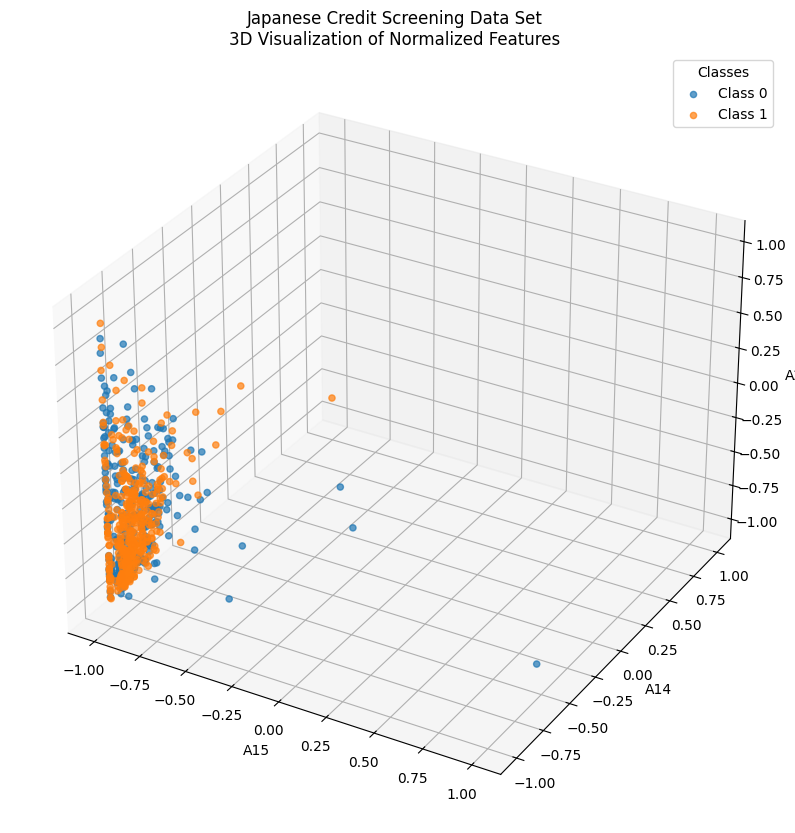

In [21]:
features = X_normalized_df.columns.tolist()


fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')


for i in np.unique(y):
    class_data = X_normalized_df[y == i]
    ax.scatter(class_data[features[0]], class_data[features[1]], class_data[features[2]],
               label=f'Class {i}', alpha=0.7)


ax.set_xlabel(features[0])
ax.set_ylabel(features[1])
ax.set_zlabel(features[2])

ax.legend(title='Classes')

plt.title('Japanese Credit Screening Data Set\n3D Visualization of Normalized Features')


plt.show()

X_normalized = X_normalized_df.copy()
y_target = y.copy()

# 6.    Разбейте набор данных на обучающую и тестовую выборки. Создайте и обучите классификатор на основе деревьев решений с глубиной дерева не более 4, определите долю верных ответов на тестовой выборке и визуализируйте границу принятия решений и построенное дерево решений. При визуализации границы принятия решений используйте два признака с наиболее высокой оценкой важности. 

In [22]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
# Разделяем данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y_target, test_size=0.2, random_state=42)

# Создаем и обучаем классификатор на основе дерева решений
clf = DecisionTreeClassifier(max_depth=4, random_state=42)
clf.fit(X_train, y_train)

# Предсказываем значения на тестовой выборке
y_pred = clf.predict(X_test)

# Оцениваем производительность модели
accuracy = accuracy_score(y_test, y_pred)
print(f"\nДоля верных ответов на тестовой выборке: {accuracy:.3f}")


Доля верных ответов на тестовой выборке: 0.645


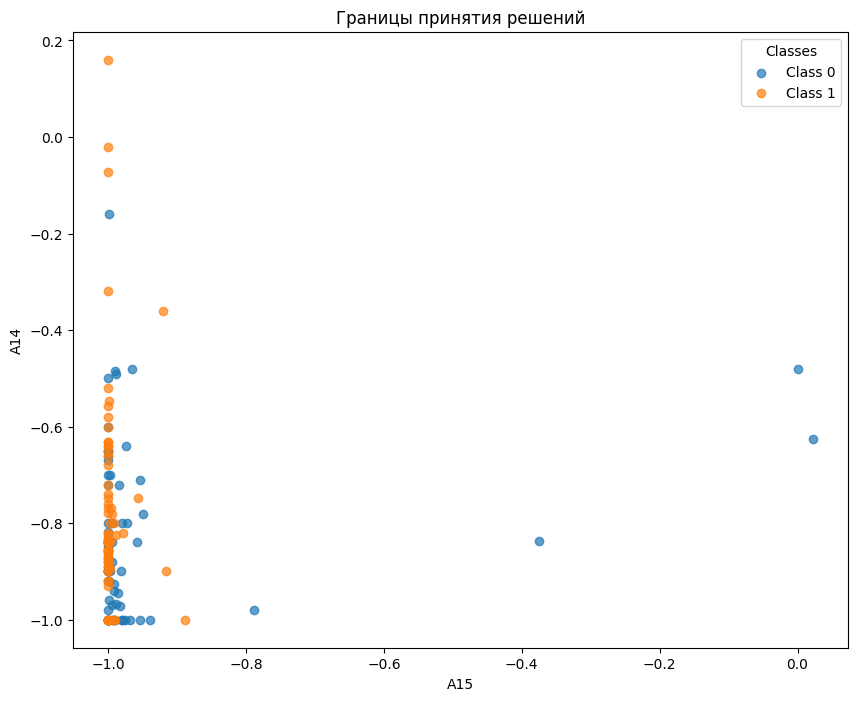

In [23]:
# Визуализация границ принятия решений
plt.figure(figsize=(10, 8))
for i in np.unique(y_test):
    class_data = X_test[y_test == i]
    plt.scatter(class_data.iloc[:, 0], class_data.iloc[:, 1],
                label=f'Class {i}', alpha=0.7)

plt.title("Границы принятия решений")
plt.xlabel(X_normalized.columns[0])
plt.ylabel(X_normalized.columns[1])
plt.legend(title='Classes')

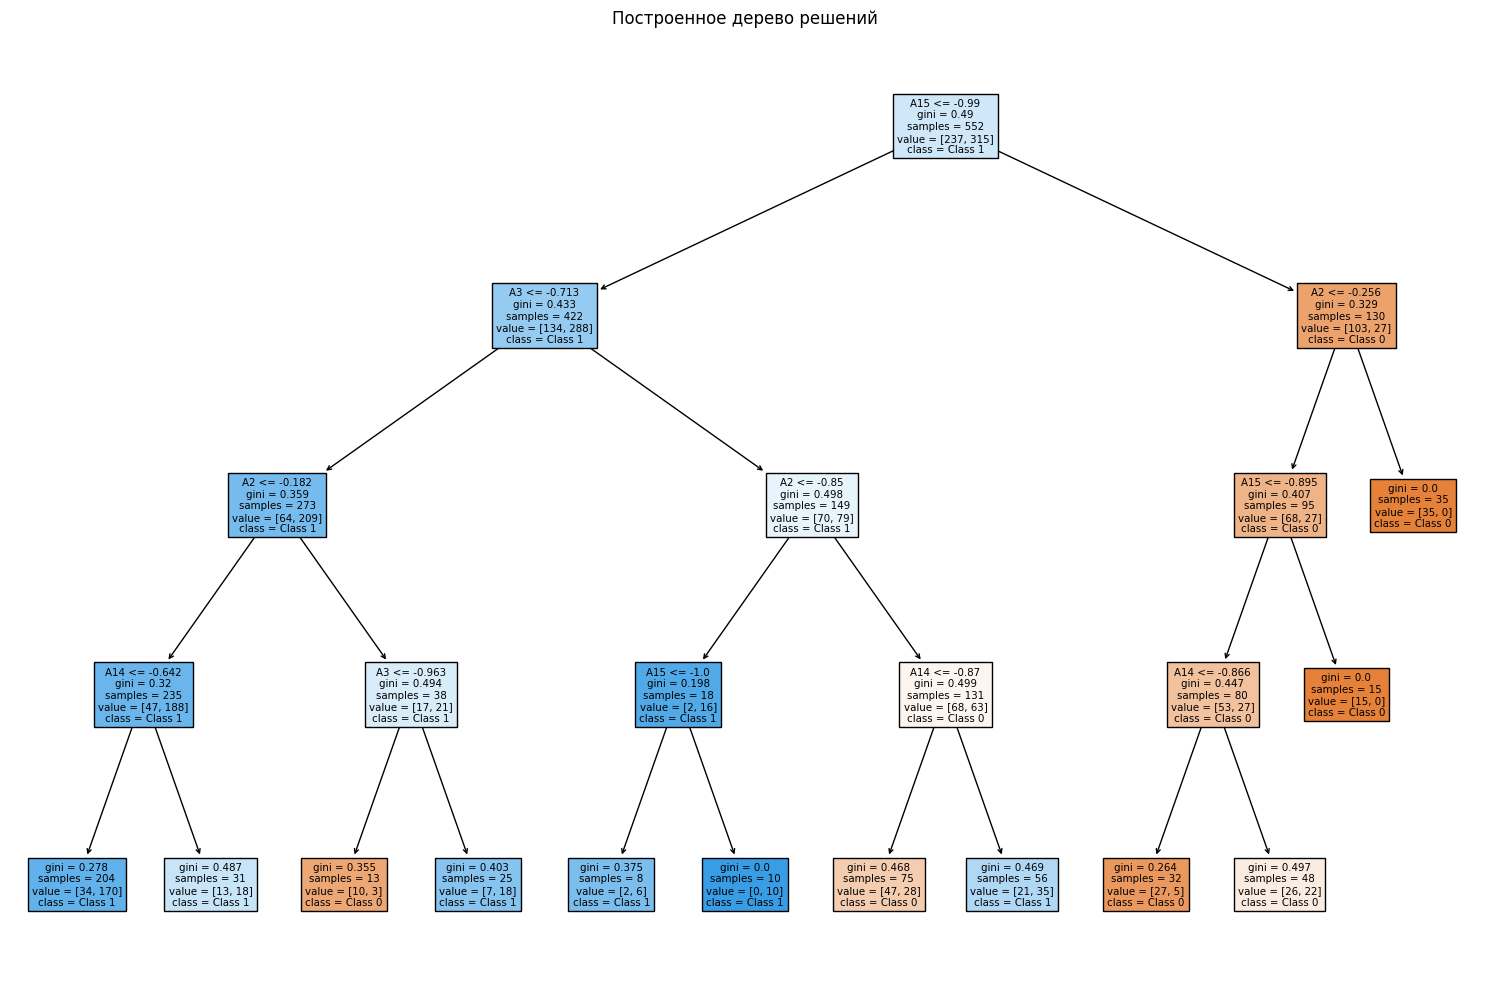

In [24]:
plt.figure(figsize=(15, 10))
plot_tree(clf, feature_names=X_normalized.columns, class_names=['Class 0', 'Class 1'], filled=True)
plt.title("Построенное дерево решений")
plt.tight_layout()
plt.show()

trained_model = clf
X_train_data = X_train.copy()
y_train_target = y_train.copy()

# 7.    Постройте и обучите дополнительные базовые классификаторы, указанные в индивидуальном задании, затем постройте из классификатора дерева решений и дополнительных классификаторов комбинированный классификатор, указанный в индивидуальном задании. Оцените производительность базовых классификаторов и комбинированного классификатора по показателю, указанному в индивидуальном задании. 

In [25]:
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import f1_score

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y_target, test_size=0.2, random_state=42)

gnb = GaussianNB()
knn = KNeighborsClassifier(n_neighbors=5)
dt = DecisionTreeClassifier(max_depth=4, random_state=42)

estimators = [('nb', gnb), ('knn', knn)]
clf = StackingClassifier(estimators=estimators, final_estimator=dt, cv=5)

In [27]:
gnb.fit(X_train, y_train)
knn.fit(X_train, y_train)
dt.fit(X_train, y_train)
clf.fit(X_train, y_train)

y_pred_gnb = gnb.predict(X_test)
y_pred_knn = knn.predict(X_test)
y_pred_dt = dt.predict(X_test)
y_pred_stacked = clf.predict(X_test)

In [28]:
f1_gnb = f1_score(y_test, y_pred_gnb, average='weighted')
f1_knn = f1_score(y_test, y_pred_knn, average='weighted')
f1_dt = f1_score(y_test, y_pred_dt, average='weighted')
f1_stacked = f1_score(y_test, y_pred_stacked, average='weighted')

print("\nПроизводительность моделей по F1-score:")
print(f"Naive Bayes: {f1_gnb:.3f}")
print(f"KNN (k=5): {f1_knn:.3f}")
print(f"Decision Tree: {f1_dt:.3f}")
print(f"Stacked Classifier: {f1_stacked:.3f}")


Производительность моделей по F1-score:
Naive Bayes: 0.503
KNN (k=5): 0.591
Decision Tree: 0.643
Stacked Classifier: 0.544


In [29]:
gnb_model = gnb
knn_model = knn
dt_model = dt
stacked_model = clf

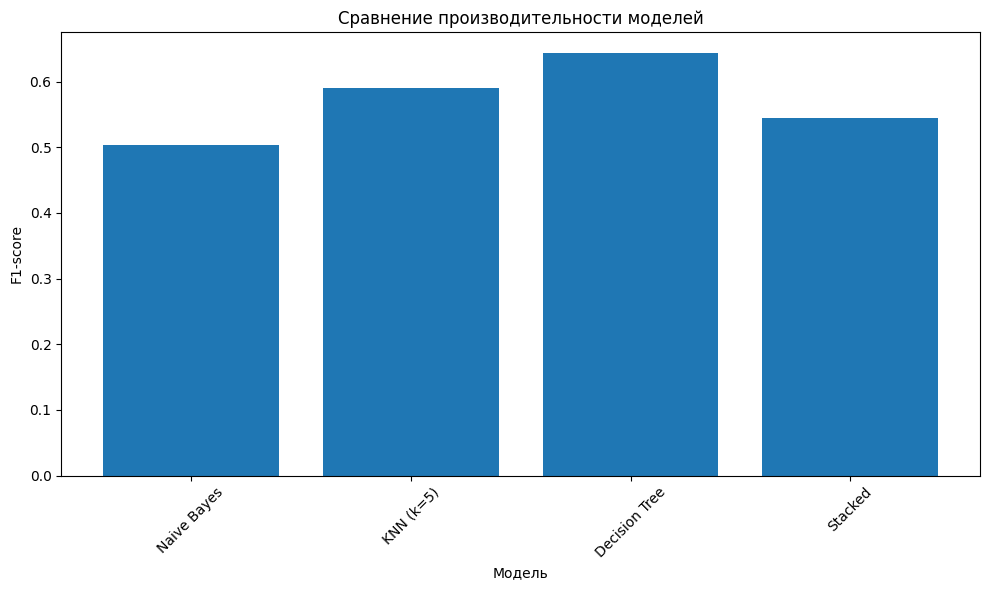

In [30]:
plt.figure(figsize=(10, 6))
models = ['Naive Bayes', 'KNN (k=5)', 'Decision Tree', 'Stacked']
f1_scores = [f1_gnb, f1_knn, f1_dt, f1_stacked]

plt.bar(models, f1_scores)
plt.xlabel('Модель')
plt.ylabel('F1-score')
plt.title('Сравнение производительности моделей')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 8.    Постройте и обучите пару ансамблевых классификаторов, указанных в индивидуальном задании, и сравните их производительность по показателю, указанному в индивидуальном задании. 

In [31]:
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

In [32]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y_target, test_size=0.2, random_state=42)

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
ada_model = AdaBoostClassifier(random_state=42)

rf_model.fit(X_train, y_train)
ada_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)
y_pred_ada = ada_model.predict(X_test)

F1-score для случайного леса: 0.624
F1-score для AdaBoost: 0.619


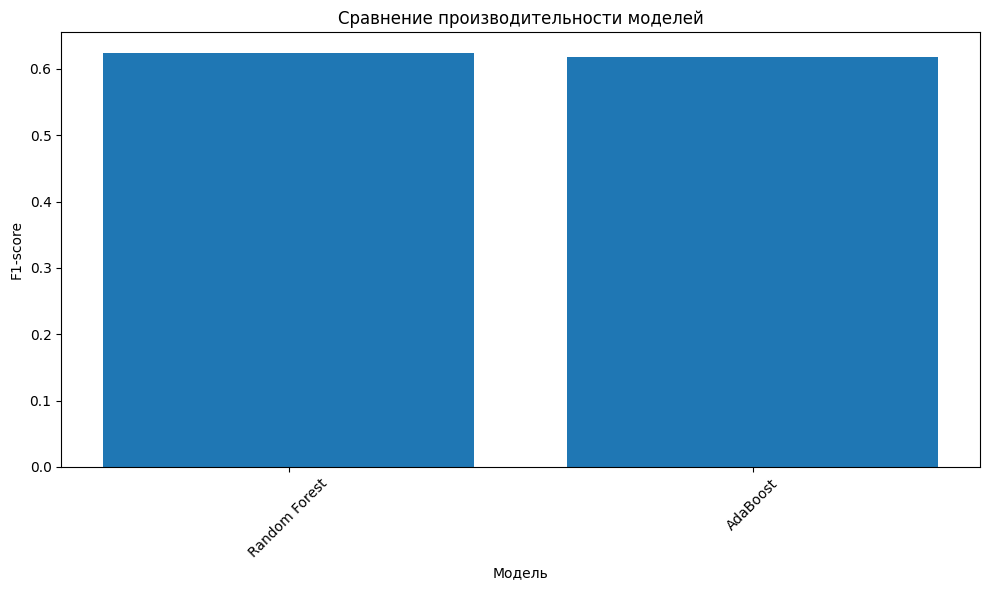

In [33]:
rf_f1 = f1_score(y_test, y_pred_rf, average='weighted')
ada_f1 = f1_score(y_test, y_pred_ada, average='weighted')

print(f"F1-score для случайного леса: {rf_f1:.3f}")
print(f"F1-score для AdaBoost: {ada_f1:.3f}")

models = ['Random Forest', 'AdaBoost']
f1_scores = [rf_f1, ada_f1]

plt.figure(figsize=(10, 6))
plt.bar(models, f1_scores)
plt.xlabel('Модель')
plt.ylabel('F1-score')
plt.title('Сравнение производительности моделей')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


importances = rf_model.feature_importances_
feature_names = X_normalized.columns.tolist()

sorted_idx = np.argsort(importances)[::-1]

# 9.    Постройте границы принятия решений ансамблевых классификаторов с визуализацией точек набора данных разных классов разными цветами. Подпишите оси и рисунок. 

 

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import train_test_split

In [35]:
top_2_features = ['A14', 'A15']
X_top_2 = X_normalized_df[top_2_features]

X_train_2d, X_test_2d, y_train, y_test = train_test_split(X_top_2, y_target, test_size=0.2, random_state=42)

rf_model_2d = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model_2d.fit(X_train_2d, y_train)

ada_model_2d = AdaBoostClassifier(random_state=42)
ada_model_2d.fit(X_train_2d, y_train)

AdaBoostClassifier(random_state=42)

In [36]:
def plot_decision_boundaries(X, y, model, model_name, feature_names):
    x_min, x_max = X.iloc[:, 0].min() - 0.1, X.iloc[:, 0].max() + 0.1
    y_min, y_max = X.iloc[:, 1].min() - 0.1, X.iloc[:, 1].max() + 0.1
    h = 0.01  

    
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = model.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1] 
    Z = Z.reshape(xx.shape)

   
    plt.figure(figsize=(10, 6))
    contour = plt.contourf(xx, yy, Z, alpha=0.6, cmap='RdYlBu', levels=np.linspace(0, 1, 100))

    
    scatter = plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y, edgecolor='k', cmap=plt.cm.RdYlBu, s=100, alpha=0.8)

    
    plt.xlabel(feature_names[0])
    plt.ylabel(feature_names[1])
    plt.title(f'{model_name} Decision Boundary with Probabilities')

    
    cbar = plt.colorbar(contour)
    cbar.set_label('Вероятность класса 1')
    cbar.set_ticks([0, 0.5, 1])
    cbar.set_ticklabels(['0', '0.5', '1'])

    plt.grid(True)
    plt.show()

C:\Users\Gigabyte\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


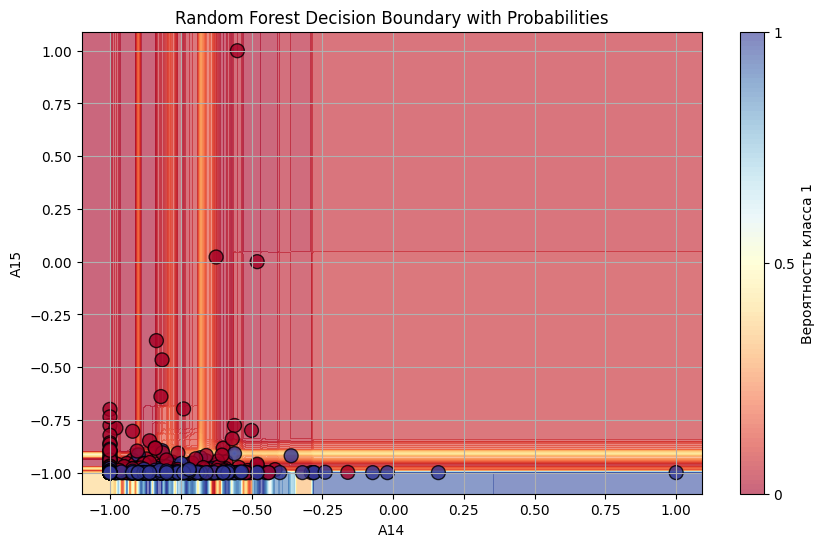

In [37]:
plot_decision_boundaries(X_top_2, y_target, rf_model_2d, 'Random Forest', top_2_features)

C:\Users\Gigabyte\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(


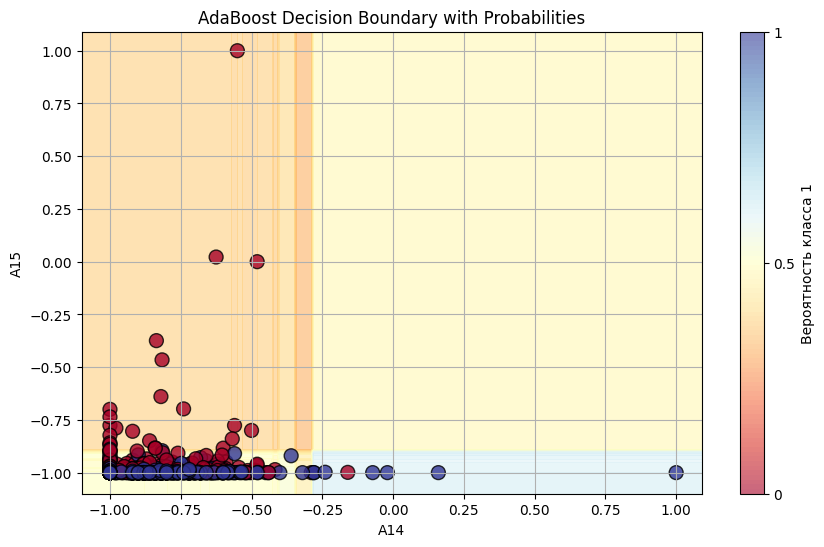

In [38]:
plot_decision_boundaries(X_top_2, y_target, ada_model_2d, 'AdaBoost', top_2_features)